In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, matthews_corrcoef


from matplotlib.lines import Line2D
from matplotlib.patches import Patch

In [30]:
file_path = 'database_2025-05-18.csv'  
df = pd.read_csv(file_path, low_memory=False)

In [33]:
df['mutated_genes']

0                                             Cre01.g028650
1                                             Cre01.g045150
2         Cre08.g375800,Cre01.g049900,Cre01.g049900 & Cr...
3                                             Cre02.g095115
4                                             Cre03.g153400
                                ...                        
113841                                                  NaN
113842                                                  NaN
113843                                                  NaN
113844                                                  NaN
113845                                                  NaN
Name: mutated_genes, Length: 113846, dtype: object

In [34]:
df[df['mutated_genes']=='Cre08.g367500']

,plate,measurement,start_date,light_regime,dark_threshold,light_threshold,num_frames,i,j,fv_fm,...,measurement_time_173,measurement_time_174,measurement_time_175,measurement_time_176,measurement_time_177,well_id,mutant_ID,feature,mutated_genes,num_mutations


In [3]:
phase1_plates = [str(i) for i in range(1, 24)]
phase1_df= df[df['plate'].isin(phase1_plates)]

In [4]:
phase1_df=phase1_df[(phase1_df['light_regime']!='5min-5min')&(phase1_df['light_regime']!='1min-5min')]

In [5]:
# clean plate 20
plate20_filter = (
    (phase1_df['plate'] == '20') &
    (
        ((phase1_df['light_regime'] == '20h_ML')        & (phase1_df['start_date'] == '2024-04-08')) |
        ((phase1_df['light_regime'] == '20h_HL')        & (phase1_df['start_date'] == '2024-04-07')) |
        ((phase1_df['light_regime'] == '2h-2h')         & (phase1_df['start_date'] == '2024-04-09')) |
        ((phase1_df['light_regime'] == '10min-10min')   & (phase1_df['start_date'] == '2024-04-10')) |
        ((phase1_df['light_regime'] == '1min-1min')     & (phase1_df['start_date'] == '2024-04-06')) |
        ((phase1_df['light_regime'] == '30s-30s')       & (phase1_df['start_date'] == '2024-05-05'))
    )
)

phase1_df = phase1_df[(phase1_df['plate'] != '20') | plate20_filter]

In [6]:
y2_cols = [f'y2_{i}' for i in range(1, 90)] 
def drop_last_valid(row):
    valid = row[y2_cols].last_valid_index()
    # if pd.notna(row[valid]):
    if valid is not None and pd.notna(row[valid]):
        row[valid] = np.nan
    return row

phase1_df1 = phase1_df.apply(drop_last_valid, axis=1)

In [7]:
# compute elapse time
measurement_cols = [f'measurement_time_{i}' for i in range(85)]  # Adjust 82 as needed
parsed_times = phase1_df1[measurement_cols].apply(
    pd.to_datetime,
    errors='coerce'  
)

for i, col in enumerate(measurement_cols):
    phase1_df1[f'elapsed_time_{i}'] = (parsed_times[col] - parsed_times['measurement_time_0']).dt.total_seconds() / 3600

/var/folders/t_/cq8kc3m112ndc44tfq9_3pgh0000gn/T/ipykernel_6687/1790441548.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  phase1_df1[f'elapsed_time_{i}'] = (parsed_times[col] - parsed_times['measurement_time_0']).dt.total_seconds() / 3600
/var/folders/t_/cq8kc3m112ndc44tfq9_3pgh0000gn/T/ipykernel_6687/1790441548.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  phase1_df1[f'elapsed_time_{i}'] = (parsed_times[col] - parsed_times['measurement_time_0']).dt.total_seconds() / 3600
/var/folders/t_/cq8kc3m112ndc44tfq9_3pgh0000gn

In [8]:
phase1_df1 ['plate'] = phase1_df1 ['plate'].astype(int)

In [10]:
phase1_df1.shape

(48258, 811)

In [11]:
## drop null rows
y2_cols = [f'y2_{i}' for i in range(1, 81)]  # or whatever your full range is
phase1_df2= phase1_df1[~(phase1_df1['mutant_ID'].isna() & phase1_df1['mutated_genes'].isna())]
phase1_df2 = phase1_df2.dropna(subset=y2_cols, how='all')

## compute 1 slope

In [12]:
def add_y2_slope_and_intercept(hdata):
    # Define time and response columns
    time_columns = [f'elapsed_time_{i}' for i in range(0, 81)]
    response_columns = [f'y2_{i}' for i in range(1, 82)]

    def compute_regression(row):
        time_values = row[time_columns].values.astype(float)
        y_values = row[response_columns].values.astype(float)
        # mask = ~np.isnan(y_values)
        mask = ~np.isnan(y_values) & ~np.isnan(time_values)


        if mask.sum() >= 2:
            model = LinearRegression()
            model.fit(time_values[mask].reshape(-1, 1), y_values[mask])

            return pd.Series({
                'y2_slope': model.coef_[0],
                'y2_intercept': model.intercept_
            })
        return pd.Series({'y2_slope': np.nan, 'y2_intercept': np.nan})

    # Apply regression row-wise
    hdata[['y2_slope', 'y2_intercept']] = hdata.apply(compute_regression, axis=1)
    
    return hdata

In [13]:
phase1_df2=add_y2_slope_and_intercept(phase1_df2)

/var/folders/t_/cq8kc3m112ndc44tfq9_3pgh0000gn/T/ipykernel_6687/755989863.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  hdata[['y2_slope', 'y2_intercept']] = hdata.apply(compute_regression, axis=1)
/var/folders/t_/cq8kc3m112ndc44tfq9_3pgh0000gn/T/ipykernel_6687/755989863.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  hdata[['y2_slope', 'y2_intercept']] = hdata.apply(compute_regression, axis=1)


In [15]:
phase1_df2

,plate,measurement,start_date,light_regime,dark_threshold,light_threshold,num_frames,i,j,fv_fm,...,elapsed_time_77,elapsed_time_78,elapsed_time_79,elapsed_time_80,elapsed_time_81,elapsed_time_82,elapsed_time_83,elapsed_time_84,y2_slope,y2_intercept
766,17,M4,2024-03-10,20h_ML,14.589689,26.166466,84,0,1,0.643787,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002280,0.508541
767,17,M4,2024-03-10,20h_ML,14.589689,26.166466,84,0,2,0.626010,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.003302,0.452590
768,17,M4,2024-03-10,20h_ML,14.589689,26.166466,84,0,3,0.682694,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.003021,0.514571
769,17,M4,2024-03-10,20h_ML,14.589689,26.166466,84,0,4,0.556010,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002564,0.367943
770,17,M4,2024-03-10,20h_ML,14.589689,26.166466,84,0,5,0.566416,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002549,0.379854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112692,12,M5,2024-04-23,10min-10min,15.736219,28.663158,164,15,19,0.591824,...,19.362778,19.529722,19.863333,20.030278,20.286111,NaN,NaN,NaN,-0.000615,0.323541
112693,12,M5,2024-04-23,10min-10min,15.736219,28.663158,164,15,20,0.561749,...,19.362778,19.529722,19.863333,20.030278,20.286111,NaN,NaN,NaN,-0.001365,0.340091
112694,12,M5,2024-04-23,10min-10min,15.736219,28.663158,164,15,21,0.531607,...,19.362778,19.529722,19.863333,20.030278,20.286111,NaN,NaN,NaN,-0.001808,0.303775
112695,12,M5,2024-04-23,10min-10min,15.736219,28.663158,164,15,22,0.576366,...,19.362778,19.529722,19.863333,20.030278,20.286111,NaN,NaN,NaN,-0.000912,0.326935


In [14]:
# Separate WT and mutants
wt_df =phase1_df2[phase1_df2['mutant_ID'] == 'WT']
mutant_df =phase1_df2[phase1_df2['mutant_ID'] != 'WT']


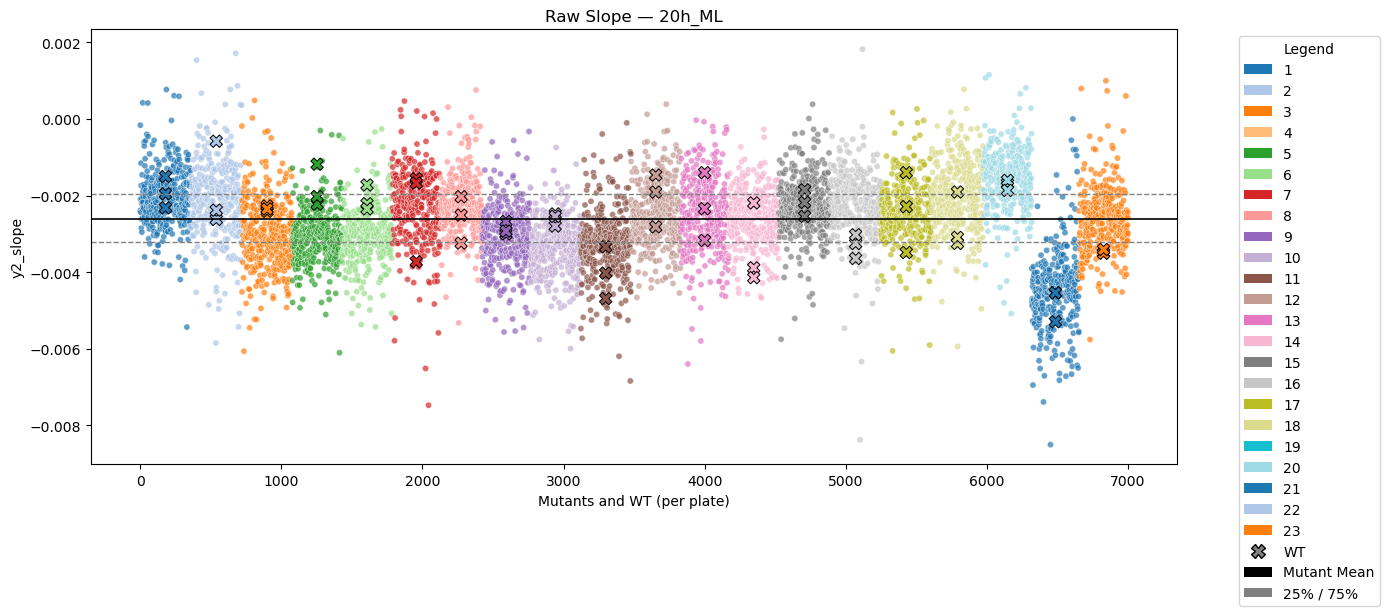

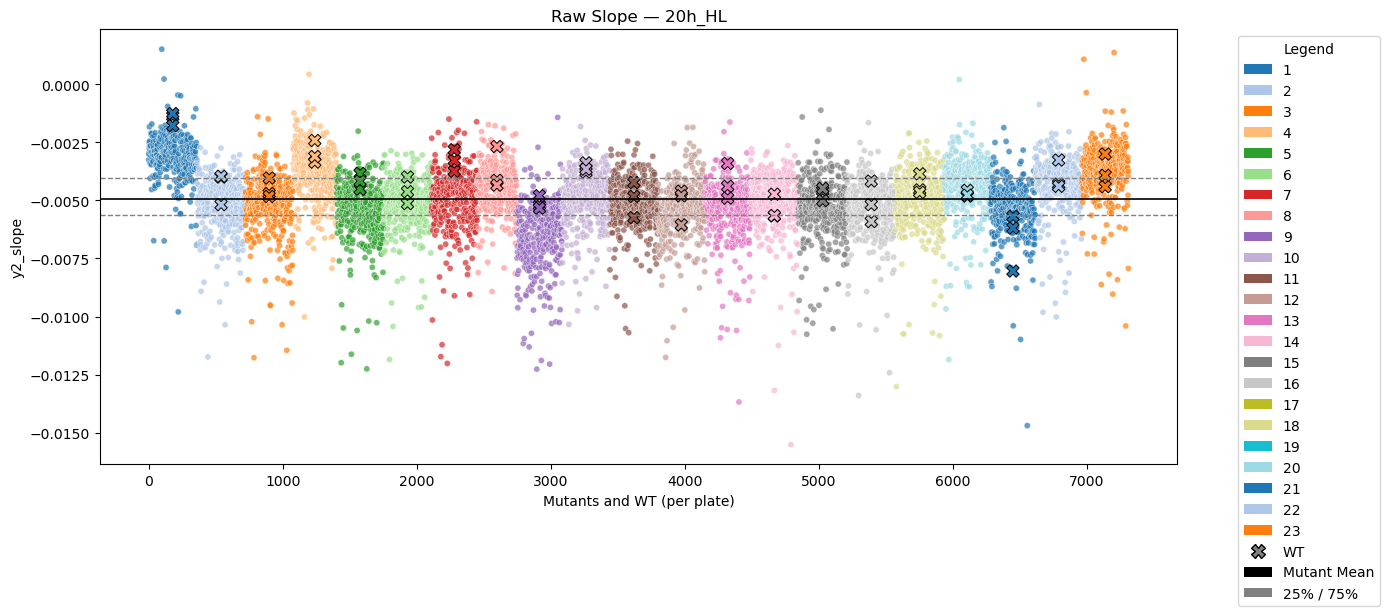

In [17]:

all_plates = list(range(1, 24))  # Plates 1 to 23
global_palette = sns.color_palette('tab20', len(all_plates))
plate_to_color = dict(zip(all_plates, global_palette))

light_regimes = ['20h_ML', '20h_HL']

for regime in light_regimes:
    # Filter mutants (excluding plate 99)
    sub_df = mutant_df[(mutant_df['light_regime'] == regime) & (mutant_df['plate'] != 99)].copy()
    sub_df = sub_df.sort_values(by='plate').reset_index(drop=True)
    sub_df['index'] = sub_df.index

    # Compute summary stats
    mean_val = sub_df['y2_slope'].mean()
    q1 = sub_df['y2_slope'].quantile(0.25)
    q3 = sub_df['y2_slope'].quantile(0.75)

    # Prepare WT data (same regime and plates)
    sub_wt_df = wt_df[
        (wt_df['light_regime'] == regime) &
        (wt_df['plate'].isin(sub_df['plate'].unique()))
    ].copy()
    plate_to_index = sub_df.groupby('plate')['index'].median().to_dict()
    sub_wt_df['index'] = sub_wt_df['plate'].map(plate_to_index)

    # Plot
    plt.figure(figsize=(14, 6))

    # Plot mutants
    sns.scatterplot(
        data=sub_df,
        x='index',
        y='y2_slope',
        hue='plate',
        palette=plate_to_color,
        alpha=0.7,
        s=20,
        legend=False
    )

    # Plot wild types
    sns.scatterplot(
        data=sub_wt_df,
        x='index',
        y='y2_slope',
        hue='plate',
        palette=plate_to_color,
        marker='X',
        s=80,
        edgecolor='black',
        legend=False
    )

    # Horizontal lines
    plt.axhline(mean_val, color='black', linestyle='-', linewidth=1.2, label='Mutant Mean')
    plt.axhline(q1, color='gray', linestyle='--', linewidth=1, label='25% Quantile')
    plt.axhline(q3, color='gray', linestyle='--', linewidth=1, label='75% Quantile')

    # Build consistent legend
    legend_elements = [
        Patch(facecolor=plate_to_color[plate], label=f'{plate}')
        for plate in all_plates
    ]
    legend_elements += [
        Line2D([0], [0], marker='X', color='w', markerfacecolor='gray',
               markeredgecolor='black', markersize=10, label='WT'),
        Patch(facecolor='black', label='Mutant Mean'),
        Patch(facecolor='gray', label='25% / 75%', linestyle='--')
    ]

    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', title="Legend")
    plt.xlabel("Mutants and WT (per plate)")
    plt.ylabel("y2_slope")
    plt.title(f"Raw Slope — {regime}")
    plt.tight_layout()
    plt.show()

## compute 2 slopes

In [18]:
df_alter = phase1_df2[phase1_df2['light_regime'].isin(['2h-2h','10min-10min', '1min-1min', '30s-30s'])]
df_alter

,plate,measurement,start_date,light_regime,dark_threshold,light_threshold,num_frames,i,j,fv_fm,...,elapsed_time_77,elapsed_time_78,elapsed_time_79,elapsed_time_80,elapsed_time_81,elapsed_time_82,elapsed_time_83,elapsed_time_84,y2_slope,y2_intercept
2681,1,M6,2024-05-04,30s-30s,15.086590,27.389332,164,0,1,0.627231,...,19.608333,19.616944,20.110556,20.119167,20.375000,NaN,NaN,NaN,0.000400,0.401531
2682,1,M6,2024-05-04,30s-30s,15.086590,27.389332,164,0,2,0.621275,...,19.608333,19.616944,20.110556,20.119167,20.375000,NaN,NaN,NaN,-0.000158,0.398080
2683,1,M6,2024-05-04,30s-30s,15.086590,27.389332,164,0,3,0.626152,...,19.608333,19.616944,20.110556,20.119167,20.375000,NaN,NaN,NaN,0.000419,0.396816
2685,1,M6,2024-05-04,30s-30s,15.086590,27.389332,164,0,5,0.589333,...,19.608333,19.616944,20.110556,20.119167,20.375000,NaN,NaN,NaN,0.000006,0.353378
2687,1,M6,2024-05-04,30s-30s,15.086590,27.389332,164,0,7,0.610352,...,19.608333,19.616944,20.110556,20.119167,20.375000,NaN,NaN,NaN,-0.000751,0.369850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112692,12,M5,2024-04-23,10min-10min,15.736219,28.663158,164,15,19,0.591824,...,19.362778,19.529722,19.863333,20.030278,20.286111,NaN,NaN,NaN,-0.000615,0.323541
112693,12,M5,2024-04-23,10min-10min,15.736219,28.663158,164,15,20,0.561749,...,19.362778,19.529722,19.863333,20.030278,20.286111,NaN,NaN,NaN,-0.001365,0.340091
112694,12,M5,2024-04-23,10min-10min,15.736219,28.663158,164,15,21,0.531607,...,19.362778,19.529722,19.863333,20.030278,20.286111,NaN,NaN,NaN,-0.001808,0.303775
112695,12,M5,2024-04-23,10min-10min,15.736219,28.663158,164,15,22,0.576366,...,19.362778,19.529722,19.863333,20.030278,20.286111,NaN,NaN,NaN,-0.000912,0.326935


In [19]:
light_ML = pd.read_csv('Data light on off/20231203 99-M3 20h ML.csv', sep=';')
light_ML = light_ML.loc[:, ~light_ML.columns.str.contains('^Unnamed')]
light_ML = light_ML.iloc[1:-1].reset_index(drop=True)

light_HL = pd.read_csv('Data light on off/20231202 99-M2 20h HL.csv', sep=';')
light_HL = light_HL.loc[:, ~light_HL.columns.str.contains('^Unnamed')]
light_HL = light_HL.iloc[1:-1].reset_index(drop=True)

light_2h = pd.read_csv('Data light on off/20231204 99-M4 2h-2h.csv', sep=';')
light_2h = light_2h.loc[:, ~light_2h.columns.str.contains('^Unnamed')]
light_2h = light_2h.iloc[1:-1].reset_index(drop=True)

light_1min = pd.read_csv('Data light on off/20231201 99-M1 1min-1min.csv', sep=';')
light_1min = light_1min.loc[:, ~light_1min.columns.str.contains('^Unnamed')]
light_1min = light_1min.iloc[1:-1].reset_index(drop=True)

light_10min = pd.read_csv('Data light on off/20231205 99-M5 10min-10min.csv', sep=';')
light_10min = light_10min.loc[:, ~light_10min.columns.str.contains('^Unnamed')]
light_10min = light_10min.iloc[1:-1].reset_index(drop=True)

light_30s=pd.read_csv('Data light on off/20240124_11-M6_30s-30s.csv', sep=';')
light_30s = light_30s.loc[:, ~light_30s.columns.str.contains('^Unnamed')]
light_30s = light_30s.iloc[1:-1].reset_index(drop=True)

In [20]:
def feature_with_light_split(df, light_dict, n_timepoints_dict):

    all_results = []

    for regime, group_df in df.groupby('light_regime'):
        if regime not in light_dict:
            continue  # skip if no light info provided for this regime

        light = light_dict[regime]
        n_timepoints = n_timepoints_dict[regime]

        # Extract ON/OFF mask
        par_values = light['PAR'].values[:n_timepoints]
        mask_on = par_values > 0
        mask_off = par_values == 0

        time_cols = [f'elapsed_time_{i}' for i in range(2, n_timepoints + 2)]
        y_cols = [f'y2_{i}' for i in range(1, n_timepoints + 1)]

        def compute_slopes(row):
            time_vals = row[time_cols].values
            y_vals = row[y_cols].values.astype(float)
        
            result = {
                'y2_slope_on': np.nan,
                'y2_intercept_on': np.nan,
                'y2_slope_off': np.nan,
                'y2_intercept_off': np.nan,
            }
        
            # ON
            valid_on = mask_on & ~np.isnan(y_vals)
            if valid_on.sum() >= 2:
                model_on = LinearRegression()
                model_on.fit(time_vals[valid_on].reshape(-1, 1), y_vals[valid_on])
                result['y2_slope_on'] = model_on.coef_[0]
                result['y2_intercept_on'] = model_on.intercept_
        
            # OFF
            valid_off = mask_off & ~np.isnan(y_vals)
            if valid_off.sum() >= 2:
                model_off = LinearRegression()
                model_off.fit(time_vals[valid_off].reshape(-1, 1), y_vals[valid_off])
                result['y2_slope_off'] = model_off.coef_[0]
                result['y2_intercept_off'] = model_off.intercept_
        
            return pd.Series(result)

        slopes = group_df.apply(compute_slopes, axis=1)
        result = pd.concat([group_df, slopes], axis=1)
        #.reset_index(drop=True)
        all_results.append(result)

    # Combine results from all regimes
    return pd.concat(all_results, ignore_index=True)

In [21]:
light_dict = {
    '2h-2h': light_2h,
    '10min-10min': light_10min,
    '1min-1min': light_1min,
    '30s-30s': light_30s,
}

n_timepoints_dict = {
    '2h-2h': 40,
    '10min-10min': 80,
    '1min-1min': 80,
    '30s-30s': 80,
}

df1 = feature_with_light_split(df_alter, light_dict, n_timepoints_dict)

In [22]:
# Separate WT and mutants
wt_df =df1[df1['mutant_ID'] == 'WT']
mutant_df =df1[df1['mutant_ID'] != 'WT']

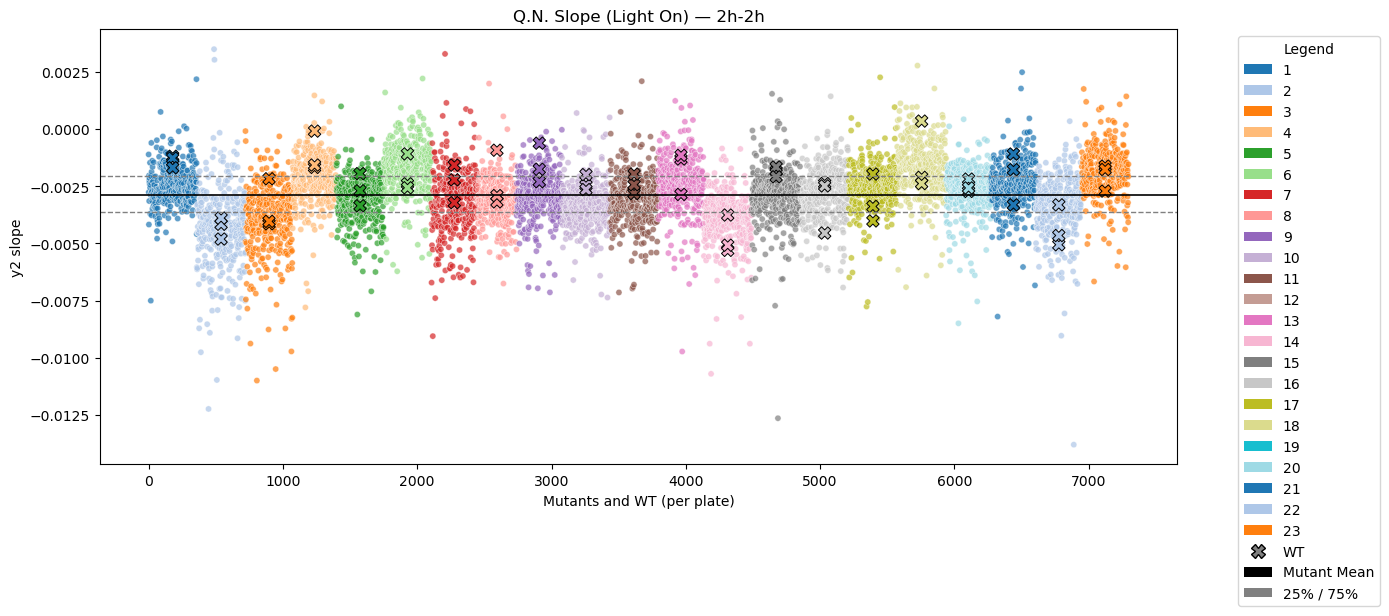

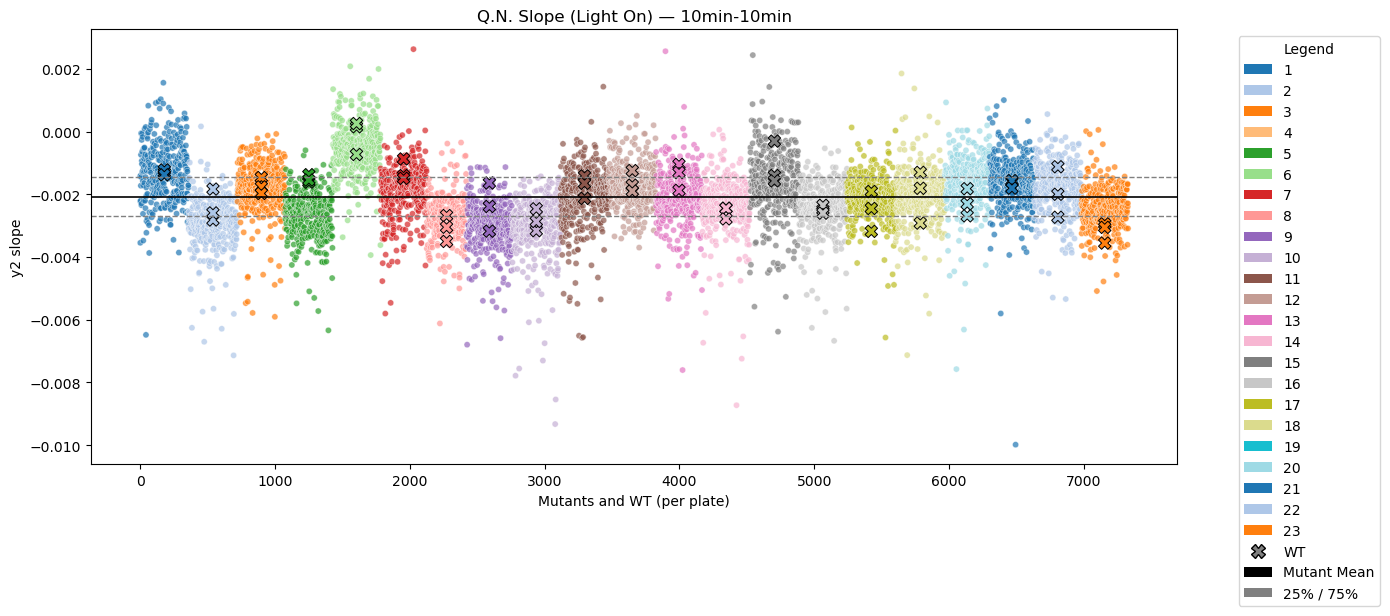

In [24]:
all_plates = list(range(1, 24))  # Plates 1 to 23
global_palette = sns.color_palette('tab20', len(all_plates))
plate_to_color = dict(zip(all_plates, global_palette))

light_regimes = ['2h-2h','10min-10min']

for regime in light_regimes:
    # Filter mutants (excluding plate 99)
    sub_df = mutant_df[(mutant_df['light_regime'] == regime) & (mutant_df['plate'] != 99)].copy()
    sub_df = sub_df.sort_values(by='plate').reset_index(drop=True)
    sub_df['index'] = sub_df.index

    # Compute summary stats
    mean_val = sub_df['y2_slope_on'].mean()
    q1 = sub_df['y2_slope_on'].quantile(0.25)
    q3 = sub_df['y2_slope_on'].quantile(0.75)

    # Prepare WT data (same regime and plates)
    sub_wt_df = wt_df[
        (wt_df['light_regime'] == regime) &
        (wt_df['plate'].isin(sub_df['plate'].unique()))
    ].copy()
    plate_to_index = sub_df.groupby('plate')['index'].median().to_dict()
    sub_wt_df['index'] = sub_wt_df['plate'].map(plate_to_index)

    # Plot
    plt.figure(figsize=(14, 6))

    # Plot mutants
    sns.scatterplot(
        data=sub_df,
        x='index',
        y='y2_slope_on',
        hue='plate',
        palette=plate_to_color,
        alpha=0.7,
        s=20,
        legend=False
    )

    # Plot wild types
    sns.scatterplot(
        data=sub_wt_df,
        x='index',
        y='y2_slope_on',
        hue='plate',
        palette=plate_to_color,
        marker='X',
        s=80,
        edgecolor='black',
        legend=False
    )

    # Horizontal lines
    plt.axhline(mean_val, color='black', linestyle='-', linewidth=1.2, label='Mutant Mean')
    plt.axhline(q1, color='gray', linestyle='--', linewidth=1, label='25% Quantile')
    plt.axhline(q3, color='gray', linestyle='--', linewidth=1, label='75% Quantile')

    # Build consistent legend
    legend_elements = [
        Patch(facecolor=plate_to_color[plate], label=f'{plate}')
        for plate in all_plates
    ]
    legend_elements += [
        Line2D([0], [0], marker='X', color='w', markerfacecolor='gray',
               markeredgecolor='black', markersize=10, label='WT'),
        Patch(facecolor='black', label='Mutant Mean'),
        Patch(facecolor='gray', label='25% / 75%', linestyle='--')
    ]

    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', title="Legend")
    plt.xlabel("Mutants and WT (per plate)")
    plt.ylabel("y2 slope")
    plt.title(f"Q.N. Slope (Light On) — {regime}")
    plt.tight_layout()
    plt.show()

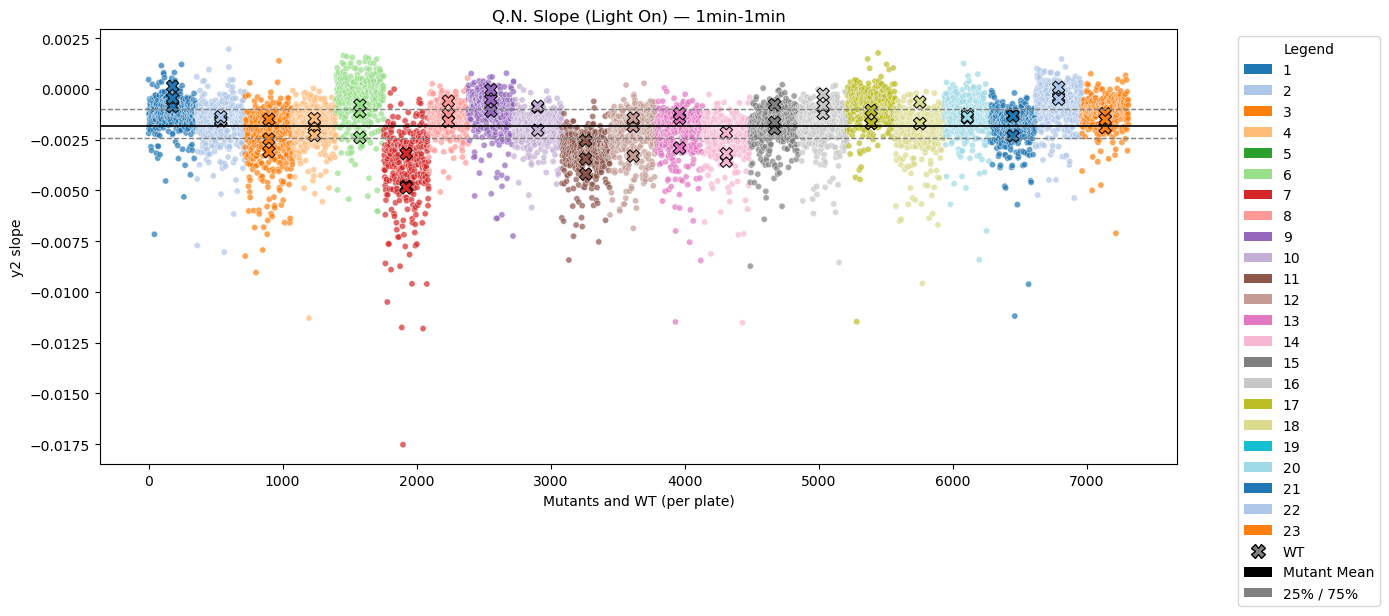

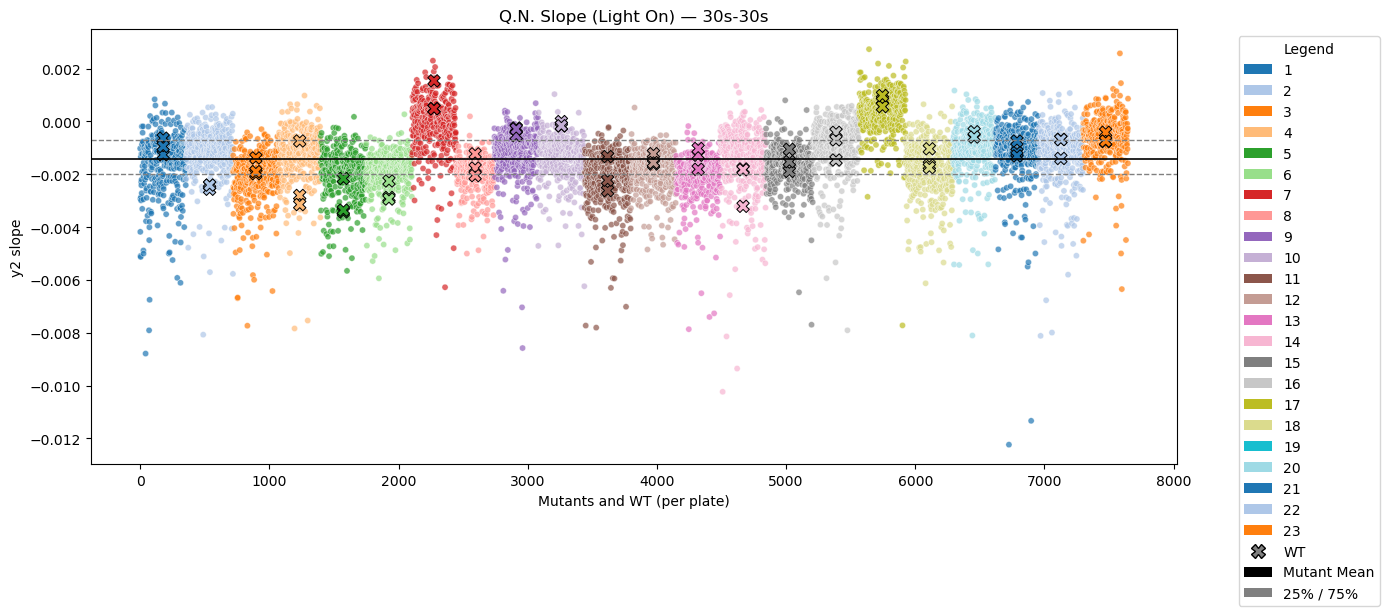

In [25]:
all_plates = list(range(1, 24))  # Plates 1 to 23
global_palette = sns.color_palette('tab20', len(all_plates))
plate_to_color = dict(zip(all_plates, global_palette))

light_regimes = ['1min-1min','30s-30s']

for regime in light_regimes:
    # Filter mutants (excluding plate 99)
    sub_df = mutant_df[(mutant_df['light_regime'] == regime) & (mutant_df['plate'] != 99)].copy()
    sub_df = sub_df.sort_values(by='plate').reset_index(drop=True)
    sub_df['index'] = sub_df.index

    # Compute summary stats
    mean_val = sub_df['y2_slope_on'].mean()
    q1 = sub_df['y2_slope_on'].quantile(0.25)
    q3 = sub_df['y2_slope_on'].quantile(0.75)

    # Prepare WT data (same regime and plates)
    sub_wt_df = wt_df[
        (wt_df['light_regime'] == regime) &
        (wt_df['plate'].isin(sub_df['plate'].unique()))
    ].copy()
    plate_to_index = sub_df.groupby('plate')['index'].median().to_dict()
    sub_wt_df['index'] = sub_wt_df['plate'].map(plate_to_index)

    # Plot
    plt.figure(figsize=(14, 6))

    # Plot mutants
    sns.scatterplot(
        data=sub_df,
        x='index',
        y='y2_slope_on',
        hue='plate',
        palette=plate_to_color,
        alpha=0.7,
        s=20,
        legend=False
    )

    # Plot wild types
    sns.scatterplot(
        data=sub_wt_df,
        x='index',
        y='y2_slope_on',
        hue='plate',
        palette=plate_to_color,
        marker='X',
        s=80,
        edgecolor='black',
        legend=False
    )

    # Horizontal lines
    plt.axhline(mean_val, color='black', linestyle='-', linewidth=1.2, label='Mutant Mean')
    plt.axhline(q1, color='gray', linestyle='--', linewidth=1, label='25% Quantile')
    plt.axhline(q3, color='gray', linestyle='--', linewidth=1, label='75% Quantile')

    # Build consistent legend
    legend_elements = [
        Patch(facecolor=plate_to_color[plate], label=f'{plate}')
        for plate in all_plates
    ]
    legend_elements += [
        Line2D([0], [0], marker='X', color='w', markerfacecolor='gray',
               markeredgecolor='black', markersize=10, label='WT'),
        Patch(facecolor='black', label='Mutant Mean'),
        Patch(facecolor='gray', label='25% / 75%', linestyle='--')
    ]

    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', title="Legend")
    plt.xlabel("Mutants and WT (per plate)")
    plt.ylabel("y2 slope")
    plt.title(f"Q.N. Slope (Light On) — {regime}")
    plt.tight_layout()
    plt.show()

In [26]:
alt_light_regimes = ['2h-2h', '10min-10min', '1min-1min', '30s-30s']

# Separate out the two subsets
df_alt= df1.copy()  # includes extra columns
df_non_alt = phase1_df2[~phase1_df2['light_regime'].isin(alt_light_regimes)].copy()

# Make sure df_non_alt has the same columns (add missing columns as NaN)
for col in df_alt.columns:
    if col not in df_non_alt.columns:
        df_non_alt[col] = np.nan

# Reorder columns to match df_alt
df_non_alt = df_non_alt[df_alt.columns]

# Concatenate the full DataFrame
combined_df = pd.concat([df_alt, df_non_alt], ignore_index=True)
combined_df.shape

(44278, 817)

In [27]:
combined_df

,plate,measurement,start_date,light_regime,dark_threshold,light_threshold,num_frames,i,j,fv_fm,...,elapsed_time_81,elapsed_time_82,elapsed_time_83,elapsed_time_84,y2_slope,y2_intercept,y2_slope_on,y2_intercept_on,y2_slope_off,y2_intercept_off
0,18,M5,2024-03-05,10min-10min,20.425804,29.181961,164,0,1,0.576961,...,20.281667,NaN,NaN,NaN,-0.002506,0.361659,-0.003266,0.183181,-0.001752,0.542707
1,18,M5,2024-03-05,10min-10min,20.425804,29.181961,164,0,2,0.651953,...,20.281667,NaN,NaN,NaN,-0.002755,0.435669,-0.003686,0.263119,-0.001830,0.611036
2,18,M5,2024-03-05,10min-10min,20.425804,29.181961,164,0,3,0.624463,...,20.281667,NaN,NaN,NaN,-0.002388,0.395038,-0.002967,0.211910,-0.001815,0.580602
3,18,M5,2024-03-05,10min-10min,20.425804,29.181961,164,0,4,0.572512,...,20.281667,NaN,NaN,NaN,-0.001649,0.355458,-0.002286,0.178296,-0.001017,0.534316
4,18,M5,2024-03-05,10min-10min,20.425804,29.181961,164,0,5,0.505590,...,20.281667,NaN,NaN,NaN,-0.001972,0.303104,-0.002241,0.136551,-0.001705,0.471653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44273,22,M2,2024-03-20,20h_HL,15.326361,24.774212,84,15,19,0.686428,...,NaN,NaN,NaN,NaN,-0.008297,0.266049,NaN,NaN,NaN,NaN
44274,22,M2,2024-03-20,20h_HL,15.326361,24.774212,84,15,20,0.528924,...,NaN,NaN,NaN,NaN,-0.002482,0.150785,NaN,NaN,NaN,NaN
44275,22,M2,2024-03-20,20h_HL,15.326361,24.774212,84,15,21,0.576597,...,NaN,NaN,NaN,NaN,-0.003268,0.181589,NaN,NaN,NaN,NaN
44276,22,M2,2024-03-20,20h_HL,15.326361,24.774212,84,15,22,0.589426,...,NaN,NaN,NaN,NaN,-0.003469,0.195558,NaN,NaN,NaN,NaN


In [28]:
combined_df.to_csv('phase1_raw_slope(5.18).csv', index=False)